In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import clip
from PIL import Image
from tqdm import tqdm
import functions as fnc
from importlib import reload
from sklearn.cluster import KMeans
from scipy.ndimage import rotate
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms

In [2]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


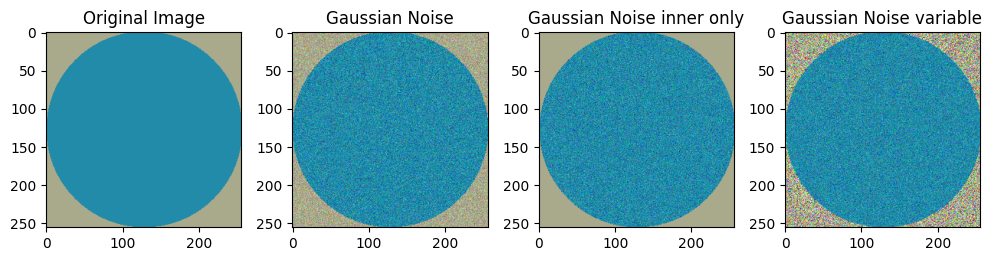

In [3]:
#create a x sized circle in the middle of a 256x256 block
mask=fnc.make_circle(128)
rgb_sphere=fnc.circle_colouring(mask)
noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,25)
noisy_image_inner_only=fnc.add_guassian_noise_to_circle(rgb_sphere,0,25,mask)
noisy_image_var=fnc.add_guassian_noise_to_circle(rgb_sphere,0,25,mask,60)


# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(rgb_sphere, cmap='gray')

plt.subplot(1, 4, 2)
plt.title('Gaussian Noise')
plt.imshow(noisy_image, cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Gaussian Noise inner only')
plt.imshow(noisy_image_inner_only, cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Gaussian Noise variable')
plt.imshow(noisy_image_var, cmap='gray')
plt.tight_layout()
plt.show()


In [75]:
inner=True#False
var=True#False

all_col=[]
all_col_mask=[]
label=1
for r in [4,16,32,128]:
    temp_row=[]
    temp_row_mask=[]
    for std in [0,10,25,40]:
        mask=fnc.make_circle(r)
        rgb_sphere=fnc.circle_colouring(mask)
        if inner:
            if var:
                std_edge=std/2
                noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask,std_edge)
            else:
                noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask)
        else:
            noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std)
        temp_row.append(noisy_image)
        temp_row_mask.append((mask).astype(int)*label)
        label+=1
    all_col.append(np.vstack(temp_row))
    all_col_mask.append(np.vstack(temp_row_mask))
image=np.hstack(all_col)
all_mask=np.hstack(all_col_mask)

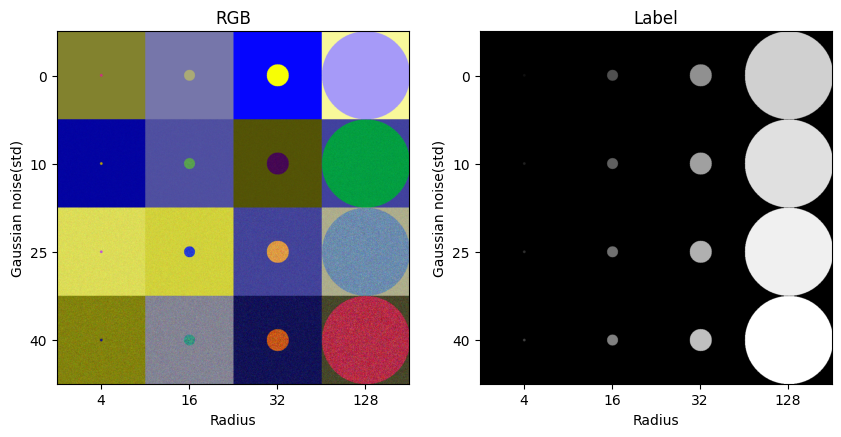

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('RGB')
plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Radius')
plt.yticks(np.arange(4)*256+128, [0,10,25,40])
plt.ylabel('Gaussian noise(std)')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Label')
plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Radius')
plt.yticks(np.arange(4)*256+128, [0,10,25,40])
plt.ylabel('Gaussian noise(std)')
plt.imshow(all_mask, cmap='gray')

In [77]:
temp_image=fnc.preprocessing_roulette(image, 
                                      {#'Crop': {'crop size': 1024, 'j':0},
                                       #'Gaussian': {'kernel size':11},
                                       #'CLAHE':{'clip limit':3}#,
                                       #'Downsample': {'fxy':4}
                                       }
                                       )
gc.collect()
torch.cuda.empty_cache()

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0,
    stability_score_thresh=0,#iou by varying cutoff in binary conversion
    box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
    crop_n_layers=0,#cut into 2**n crops
    crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0,
    #min_mask_region_area=2000,
)
with torch.no_grad():
    masks = mask_generator.generate(temp_image)
#logit_scale=1000
print(len(masks))

No process performed, returning input


432


In [50]:
bboxes = torch.tensor([mask['bbox'] for mask in masks], device=DEVICE, dtype=torch.float)
scores = torch.tensor([mask['predicted_iou'] for mask in masks], device=DEVICE, dtype=torch.float)
labels = torch.zeros_like(torch.tensor([mask['bbox'] for mask in masks], device=DEVICE)[:, 0])#torch.tensor(np.ones(len(masks)), device=DEVICE, dtype=torch.int)

keep = batched_nms(bboxes, scores, labels, 0.3)
masks=[masks[i] for i in keep]

print('After nms filter',len(masks))

After nms filter 378


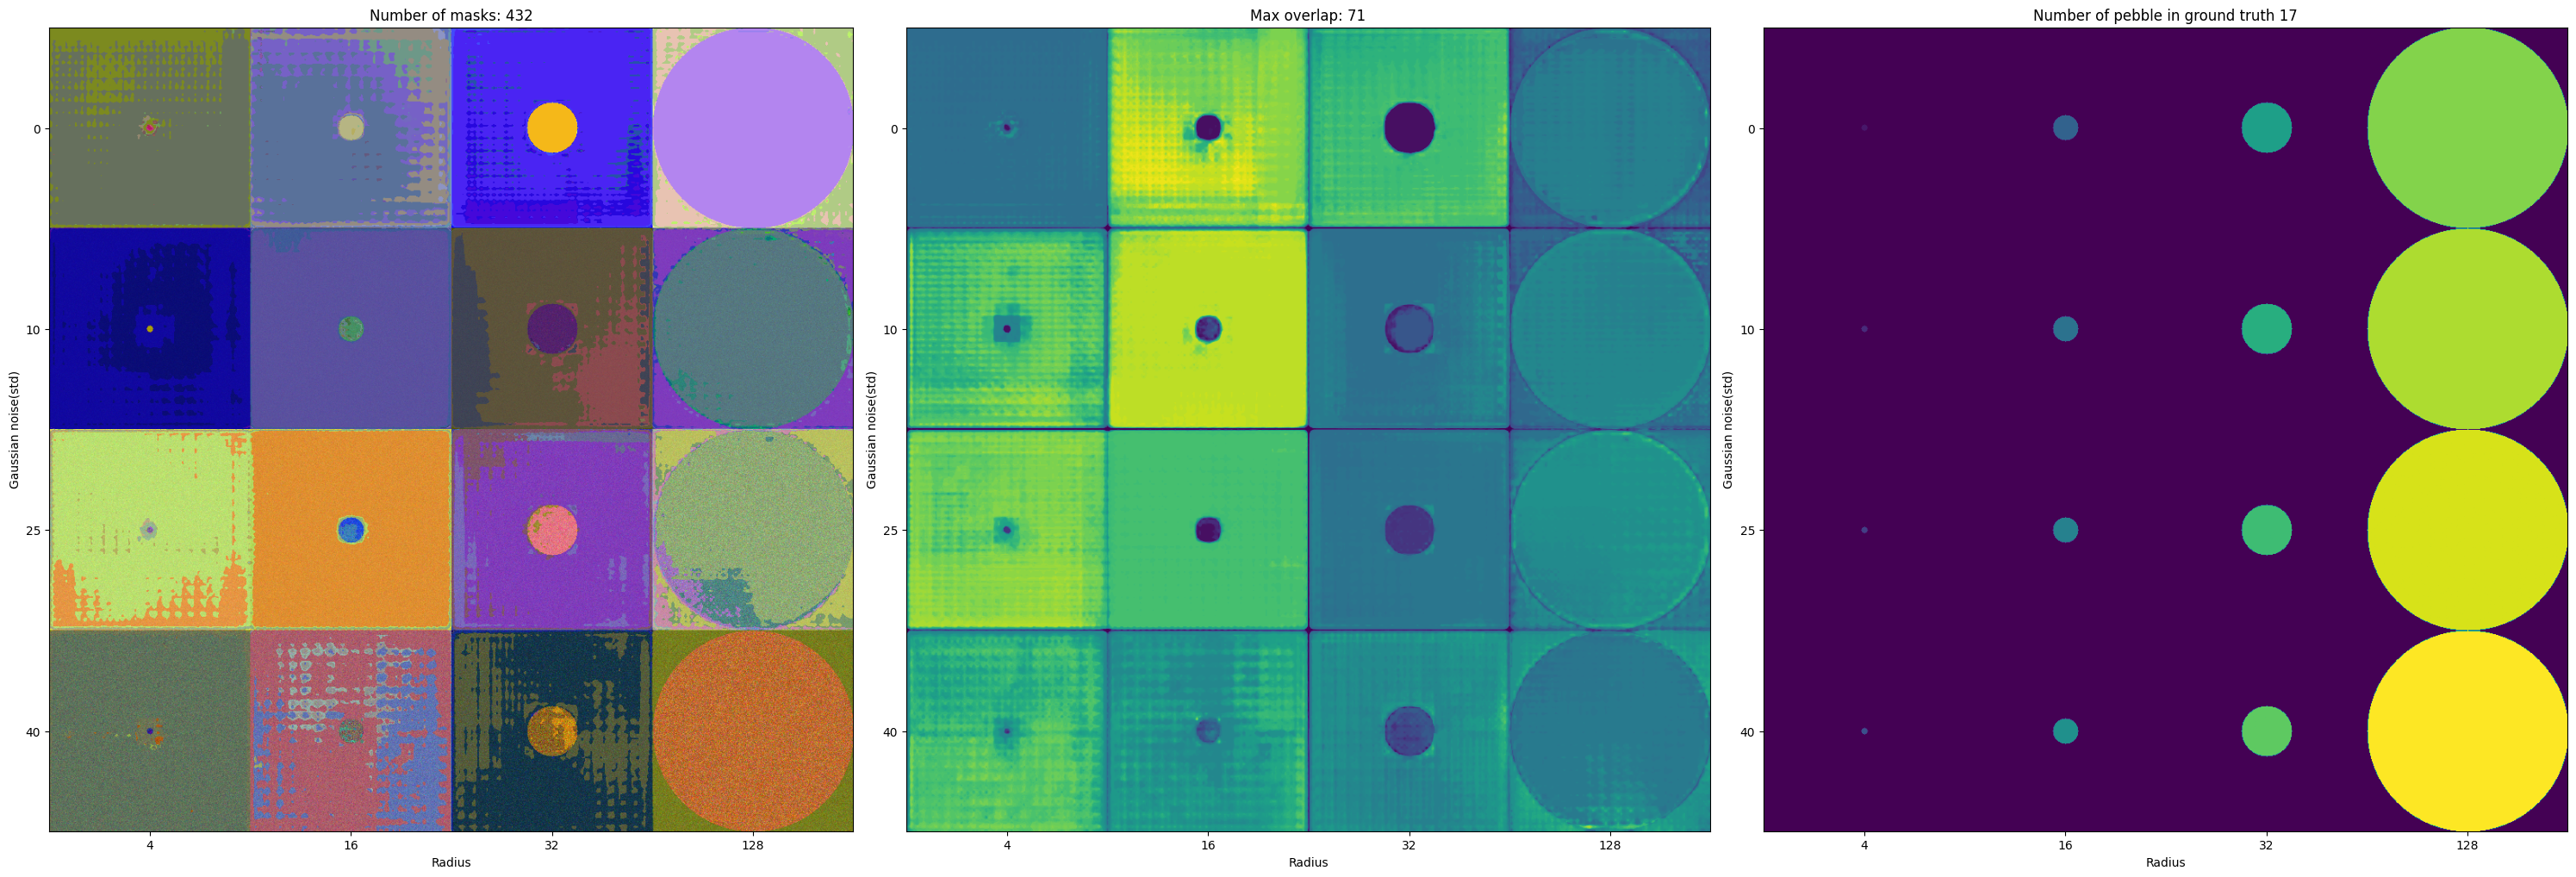

In [78]:
fig, ax = plt.subplots(1,3,figsize=(30,20))
ax=ax.flatten()
i=0
ax[i*2].imshow(temp_image)
fnc.show_anns_mod_ax(masks, ax[i*2], label=None, sort=False)
ax[i*2].set_title(f'Number of masks: {len(masks)}')
#ax[i*2].axis('off')
ax[i*2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
ax[i*2].set_xlabel('Radius')
ax[i*2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
ax[i*2].set_ylabel('Gaussian noise(std)')

list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in masks]
ar_masks=np.stack(list_of_masks) 
ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')  
ax[i*2+1].set_xticks(np.arange(4)*256+128, [4,16,32,128])
ax[i*2+1].set_xlabel('Radius')
ax[i*2+1].set_yticks(np.arange(4)*256+128, [0,10,25,40])
ax[i*2+1].set_ylabel('Gaussian noise(std)')

ax[i*2+2].imshow(all_mask)  
ax[i*2+2].set_title(f'Number of pebble in ground truth {len(np.unique(all_mask))}')   
ax[i*2+2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
ax[i*2+2].set_xlabel('Radius')
ax[i*2+2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
ax[i*2+2].set_ylabel('Gaussian noise(std)')

plt.tight_layout()
plt.show()

In [79]:
#prep selection
seg_labels=(np.unique(all_mask)[1:])

seg_size=[]
for seg in seg_labels:
    seg_size.append(np.sum(all_mask==seg))

seg_size_sort_idx=np.argsort(seg_size)

list_of_label=[(all_mask==seg_labels[index]).astype(np.uint8) for index in seg_size_sort_idx]
ar_label=np.stack(list_of_label)

list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
ar_masks=np.stack(list_of_masks)

ar_all=np.stack(list_of_label+list_of_masks)
list_of_centroid = [fnc.get_centroid(ar_all[i]) for i in range(len(ar_all))]
ar_all.shape

ar_all_flat=ar_all.reshape((ar_all.shape[0],ar_all.shape[1]*ar_all.shape[2]))
set_overlap = set()

# Iterate through each column of the array
for i in range(ar_all_flat.shape[1]):
    # for each pixel find out the idex of mask where the pixel was in a mask
    nz = np.where(ar_all_flat[:, i] != 0)[0]
    
    # if there are overlap of mask
    if len(nz) > 1:
        nz_tuple = tuple(nz)
        set_overlap.add(nz_tuple)

# Convert the set back to a list if needed
list_overlap = list(set_overlap)


#centroid based selection
from sklearn.neighbors import KDTree
tree = KDTree(list_of_centroid)              
k=4
_, ind = tree.query(list_of_centroid[:len(list_of_label)], k=k)

# get nearest centroid iou
kdc_iou=[]
nearest_mask_pick=[]
for match in ind:
    #check if nearest neighbor is not a label
    j=1
    while match[j]<len(list_of_label):
        j+=1
    if j<k:
        kdc_iou.append(fnc.iou(ar_all[match[0]],ar_all[match[j]]))
        nearest_mask_pick.append(match[j])
    else:
        kdc_iou.append(-0.1)

    
# get all average and max iou
overlap_by_label=[]
max_iou=[]
avg_iou=[]
max_mask_pick=[]
for i in range(len(list_of_label)):
    all_pairs=[tup for tup in list_overlap if i in tup]
    if len(all_pairs)>0:
        overlap_with_i=np.unique(np.hstack(all_pairs))[1:]
        overlap_by_label.append(overlap_with_i)
        agg_iou=[]
        for j in overlap_with_i:
            agg_iou.append(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))
        avg_iou.append(np.mean(agg_iou))
        max_iou.append(np.max(agg_iou))
        max_mask_pick.append(overlap_with_i[np.argmax(agg_iou)])
    else:
        overlap_by_label.append(np.array([]))
        avg_iou.append(-0.1)
        max_iou.append(-0.1)

In [86]:
nearest_subset_masks=[masks[i-len(list_of_label)] for i in nearest_mask_pick]
max_subset_masks=[masks[i-len(list_of_label)] for i in max_mask_pick]

In [84]:
xl=[1,3,5,7,9,11,13,15,17,19,21]
All_nearest_iou=[]
All_max_iou=[]
for k in xl:
    temp_image=fnc.preprocessing_roulette(image, 
                                          {#'Crop': {'crop size': 1024, 'j':0},
                                              'Gaussian': {'kernel size':k},
                                              #'CLAHE':{'clip limit':3}#,
                                              # #'Downsample': {'fxy':4}
                                              })
    gc.collect()
    torch.cuda.empty_cache()

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=12,
        pred_iou_thresh=0,
        stability_score_thresh=0,#iou by varying cutoff in binary conversion
        box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
        crop_n_layers=0,#cut into 2**n crops
        crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
        crop_n_points_downscale_factor=1,
        crop_overlap_ratio=0,
        #min_mask_region_area=2000,
    )
    with torch.no_grad():
        masks = mask_generator.generate(temp_image)
    #logit_scale=1000

    #prep selection
    seg_labels=(np.unique(all_mask)[1:])

    seg_size=[]
    for seg in seg_labels:
        seg_size.append(np.sum(all_mask==seg))

    seg_size_sort_idx=np.argsort(seg_size)

    list_of_label=[(all_mask==seg_labels[index]).astype(np.uint8) for index in seg_size_sort_idx]
    #list_of_label_centroid = [fnc.get_centroid(mask) for mask in list_of_label]
    ar_label=np.stack(list_of_label)

    list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
    #list_of_mask_centroid = [fnc.get_centroid(mask) for mask in list_of_masks]
    ar_masks=np.stack(list_of_masks)

    ar_all=np.stack(list_of_label+list_of_masks)
    list_of_centroid = [fnc.get_centroid(ar_all[i]) for i in range(len(ar_all))]
    ar_all.shape

    ar_all_flat=ar_all.reshape((ar_all.shape[0],ar_all.shape[1]*ar_all.shape[2]))
    set_overlap = set()

    # Iterate through each column of the array
    for i in range(ar_all_flat.shape[1]):
        # for each pixel find out the idex of mask where the pixel was in a mask
        nz = np.where(ar_all_flat[:, i] != 0)[0]
        
        # if there are overlap of mask
        if len(nz) > 1:
            nz_tuple = tuple(nz)
            set_overlap.add(nz_tuple)

    # Convert the set back to a list if needed
    list_overlap = list(set_overlap)


    #centroid based selection
    from sklearn.neighbors import KDTree
    tree = KDTree(list_of_centroid)              
    k=4
    _, ind = tree.query(list_of_centroid[:len(list_of_label)], k=k)

    # get nearest centroid iou
    kdc_iou=[]
    nearest_mask_pick=[]
    for match in ind:
        #check if nearest neighbor is not a label
        j=1
        while match[j]<len(list_of_label):
            j+=1
        if j<k:
            kdc_iou.append(fnc.iou(ar_all[match[0]],ar_all[match[j]]))
            nearest_mask_pick.append(match[j])
        else:
            kdc_iou.append(-0.1)

        
    # get all average and max iou
    overlap_by_label=[]
    max_iou=[]
    avg_iou=[]
    max_mask_pick=[]
    for i in range(len(list_of_label)):
        all_pairs=[tup for tup in list_overlap if i in tup]
        if len(all_pairs)>0:
            overlap_with_i=np.unique(np.hstack(all_pairs))[1:]
            overlap_by_label.append(overlap_with_i)
            agg_iou=[]
            for j in overlap_with_i:
                agg_iou.append(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))
            avg_iou.append(np.mean(agg_iou))
            max_iou.append(np.max(agg_iou))
            max_mask_pick.append(overlap_with_i[np.argmax(agg_iou)])
        else:
            overlap_by_label.append(np.array([]))
            avg_iou.append(-0.1)
            max_iou.append(-0.1)
    All_nearest_iou.append(kdc_iou)
    All_max_iou.append(max_iou)

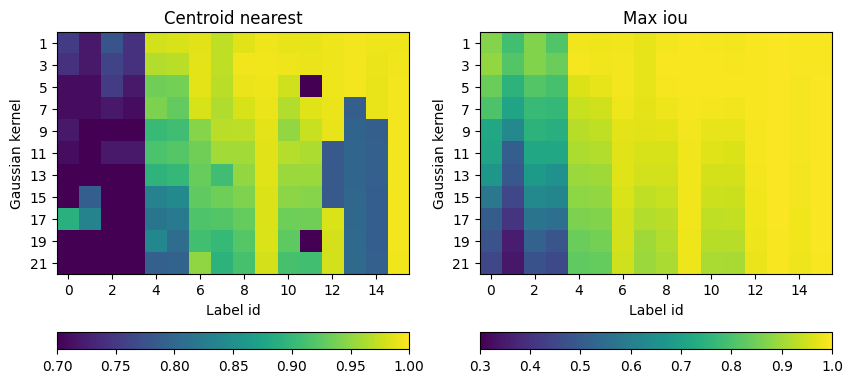

In [85]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Centroid nearest')
#plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Label id')
plt.yticks(range(len(All_nearest_iou)), xl)
plt.ylabel('Gaussian kernel')
plt.imshow(np.array(All_nearest_iou), vmin=0.7,vmax=1)
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.title('Max iou')
#plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Label id')
plt.yticks(range(len(All_max_iou)), xl)
plt.ylabel('Gaussian kernel')
plt.imshow(np.array(All_max_iou), vmin=0.3,vmax=1)
plt.colorbar(orientation='horizontal')

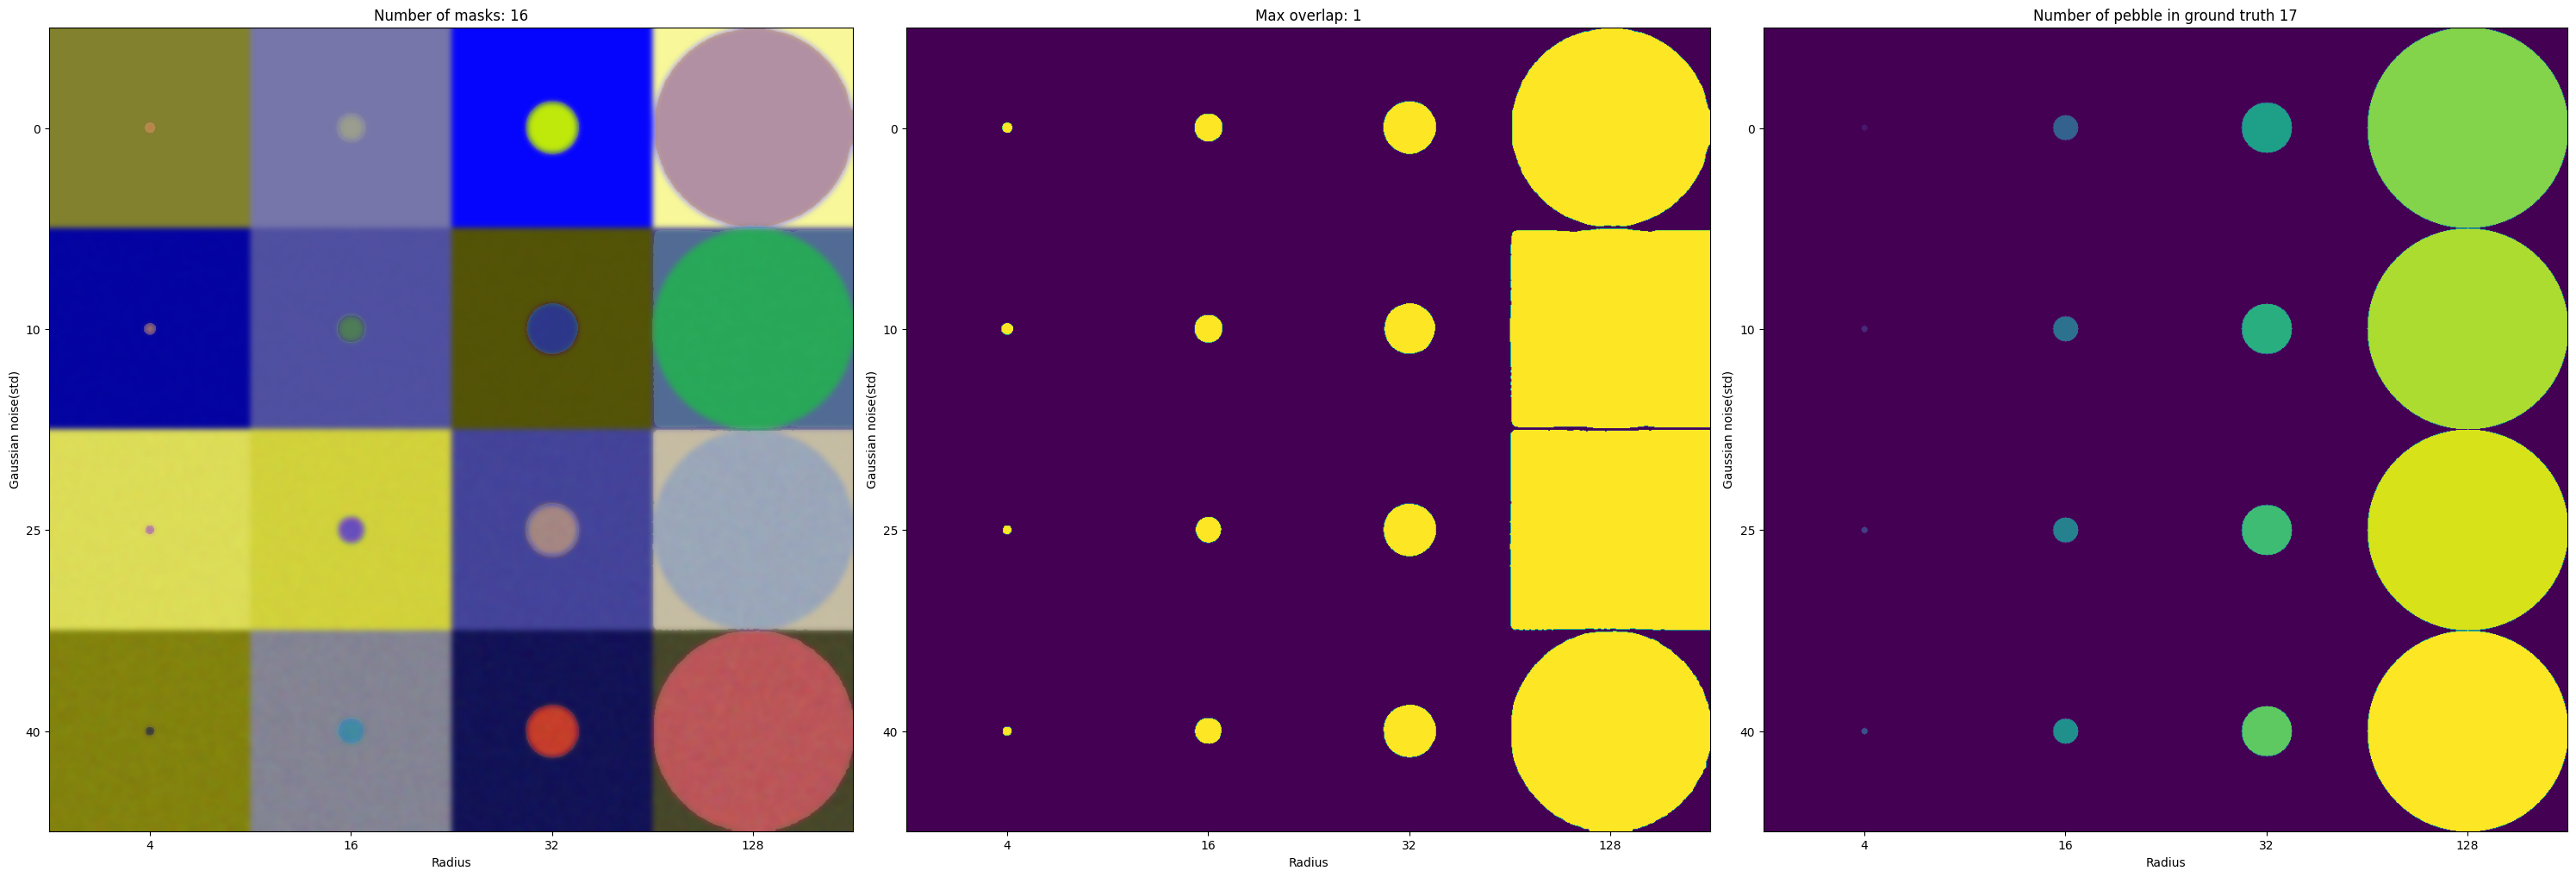

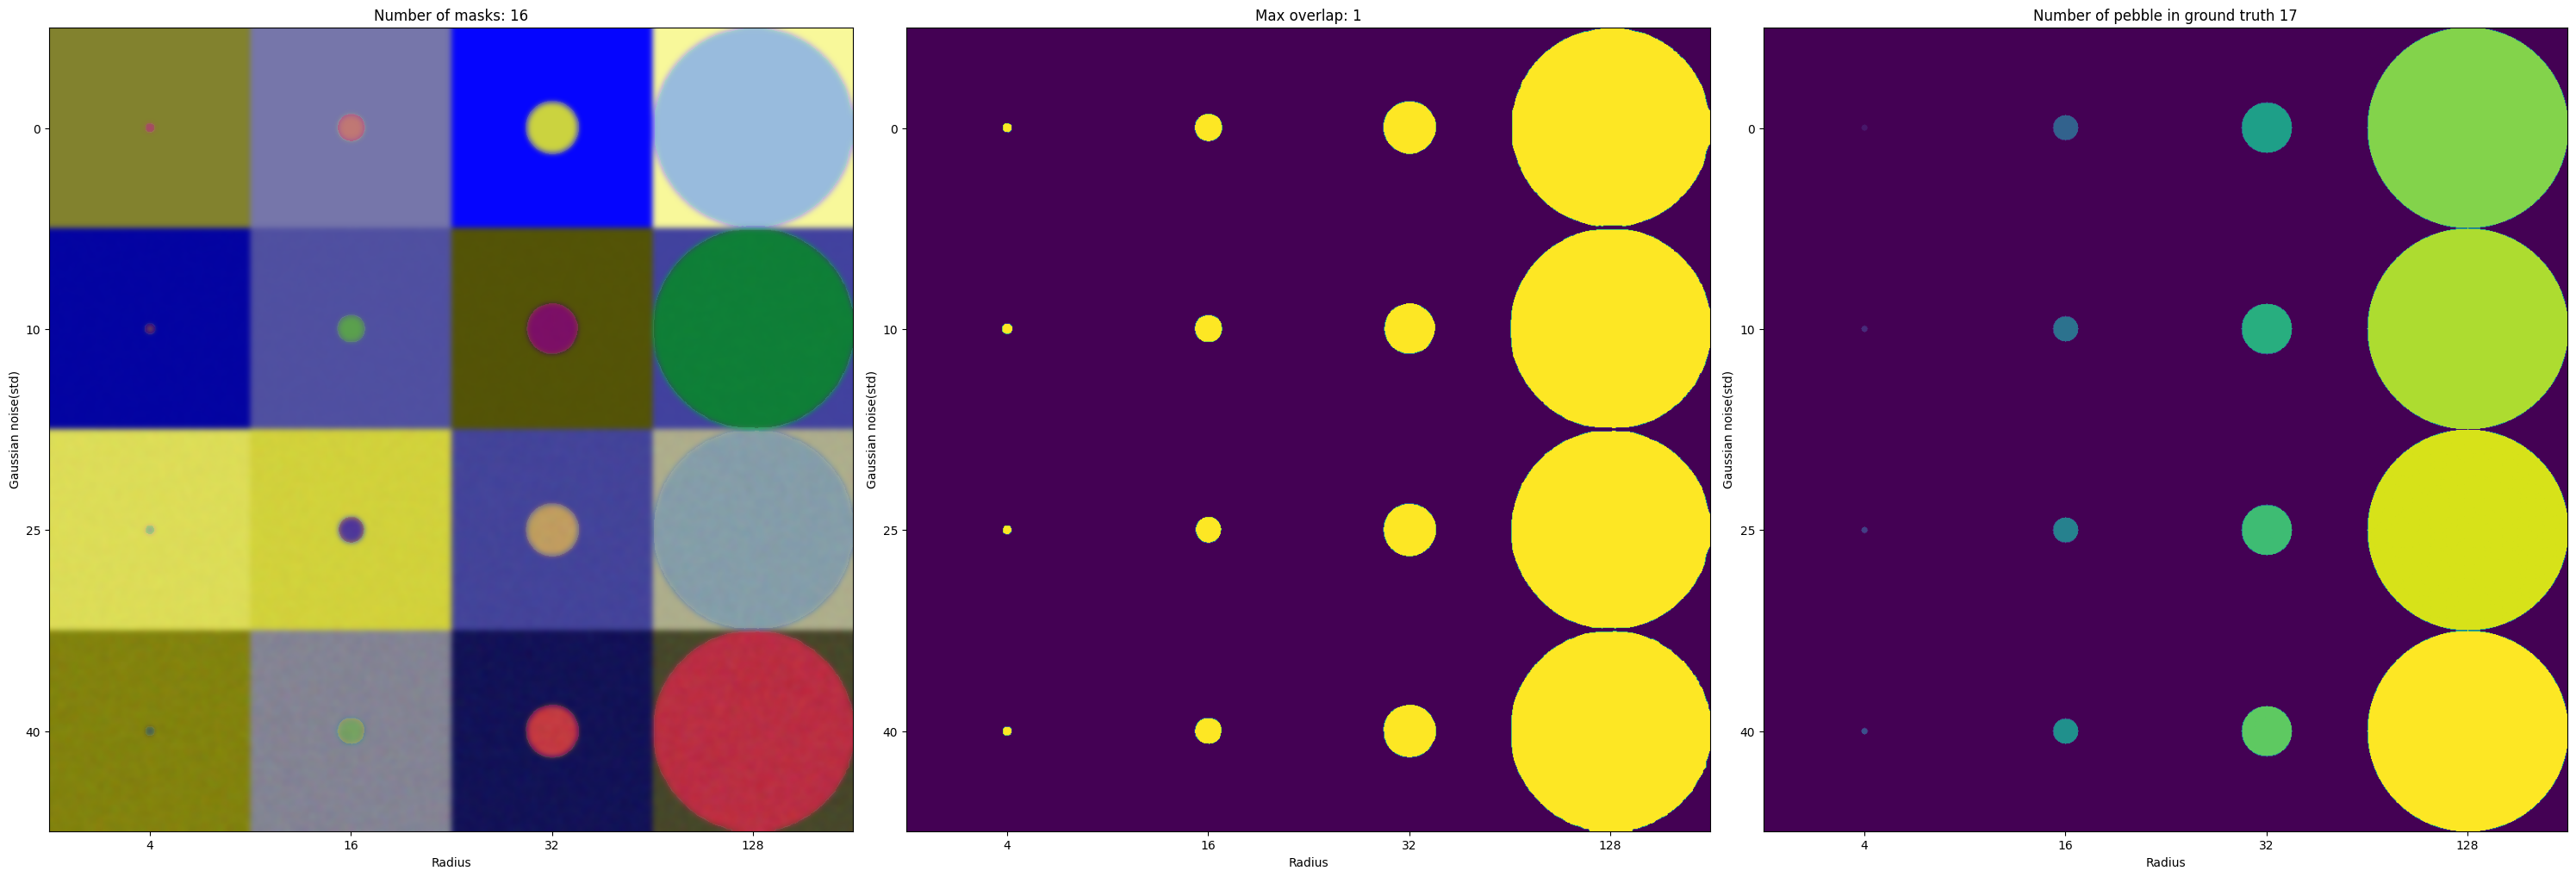

In [87]:
for t_masks in [nearest_subset_masks,max_subset_masks]:
    fig, ax = plt.subplots(1,3,figsize=(30,20))
    ax=ax.flatten()
    i=0
    ax[i*2].imshow(temp_image)
    fnc.show_anns_mod_ax(t_masks, ax[i*2], label=None, sort=False)
    #ax[i*2].axis('off')
    ax[i*2].set_title(f'Number of masks: {len(t_masks)}')
    ax[i*2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2].set_xlabel('Radius')
    ax[i*2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2].set_ylabel('Gaussian noise(std)')

    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in t_masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')  
    ax[i*2+1].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2+1].set_xlabel('Radius')
    ax[i*2+1].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2+1].set_ylabel('Gaussian noise(std)')

    ax[i*2+2].imshow(all_mask)  
    ax[i*2+2].set_title(f'Number of pebble in ground truth {len(np.unique(all_mask))}')   
    ax[i*2+2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2+2].set_xlabel('Radius')
    ax[i*2+2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2+2].set_ylabel('Gaussian noise(std)')

    plt.tight_layout()
    plt.show()

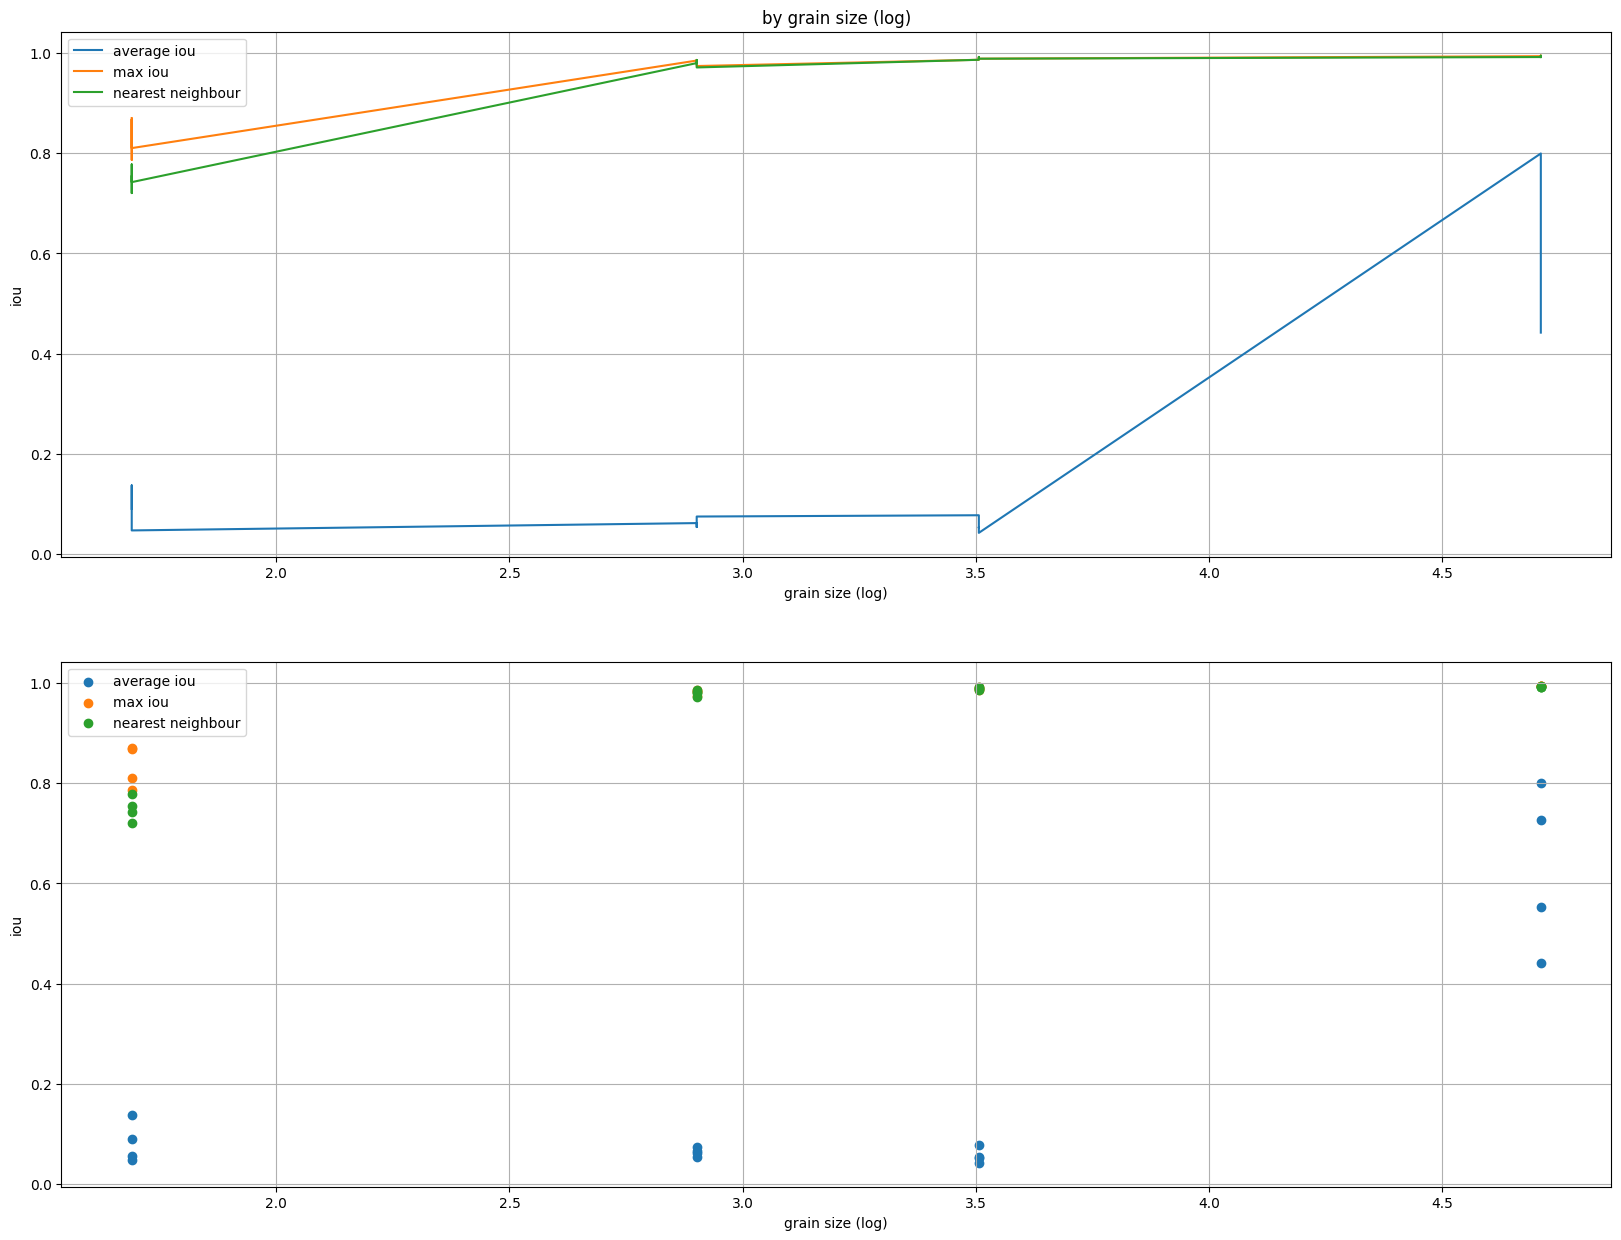

In [82]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain size (log)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain size (log)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain size (log)')
plt.show()

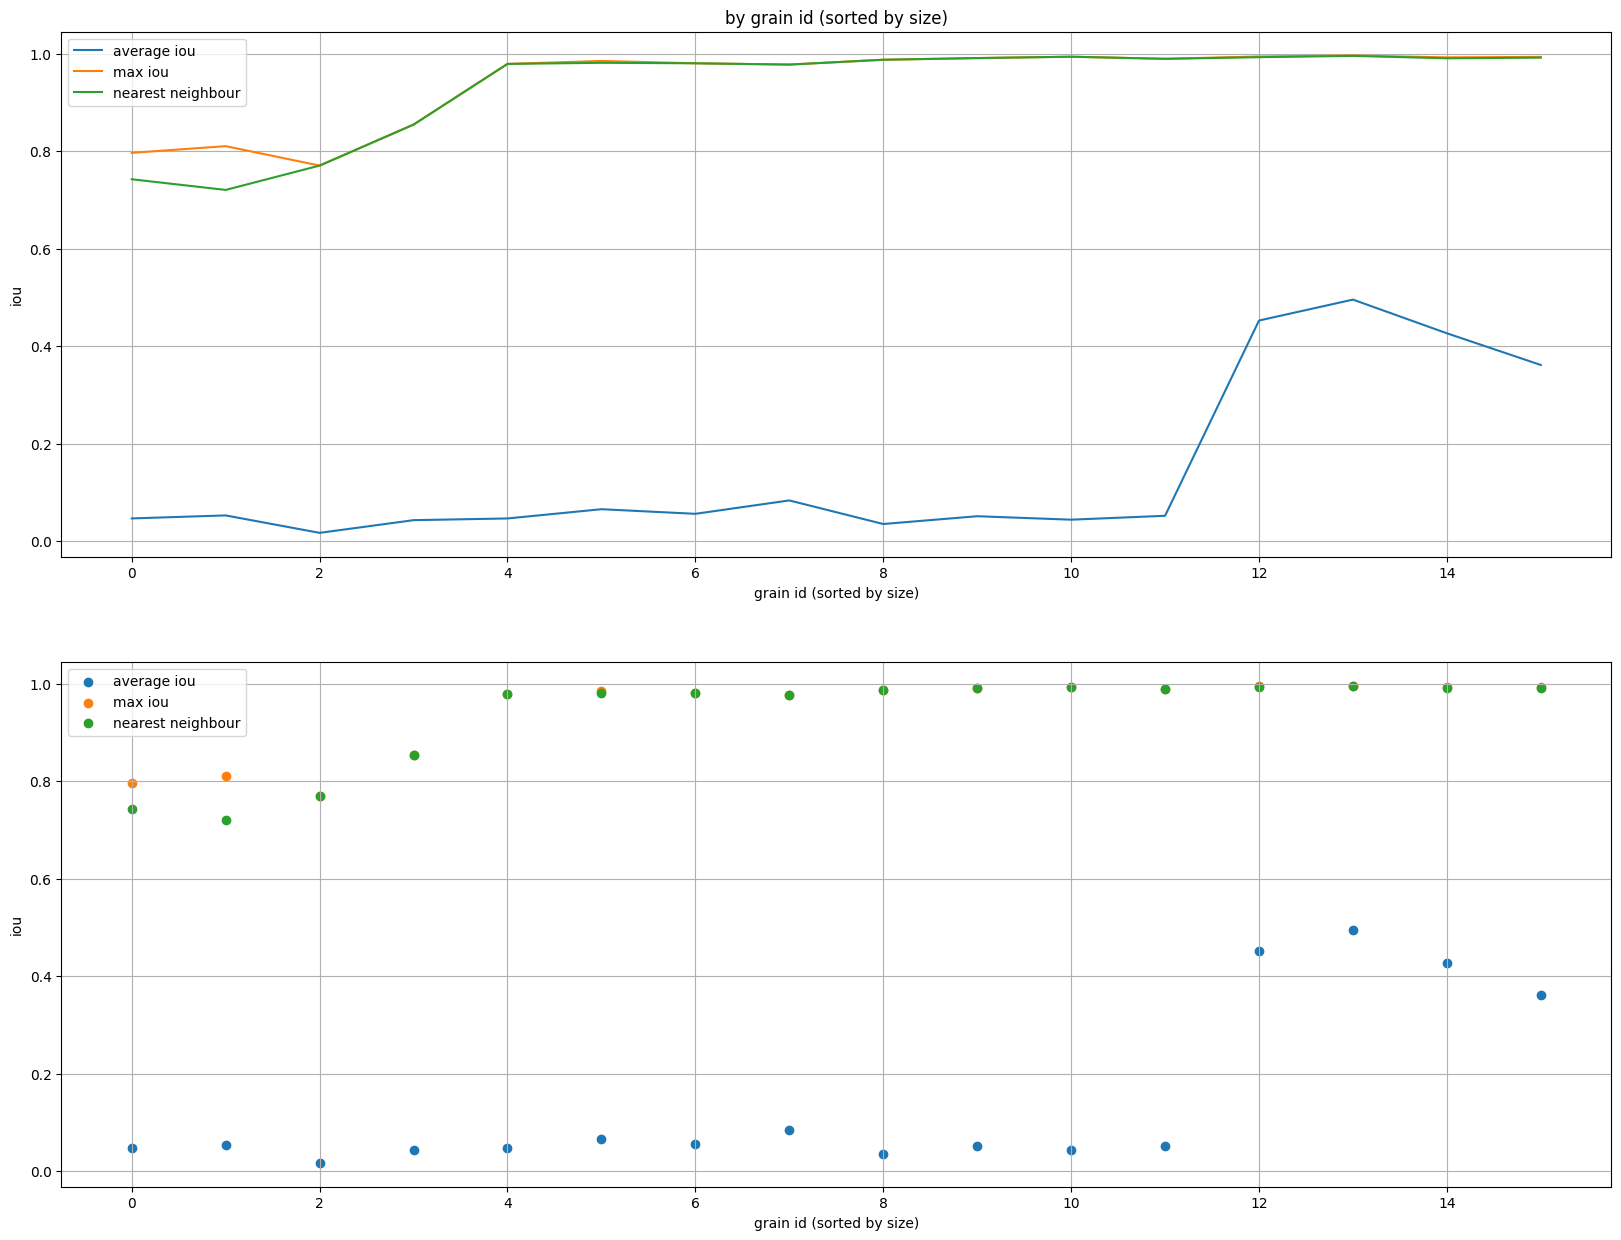

In [15]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(range(len(list_of_label)),avg_iou,label='average iou')
ax[0].plot(range(len(list_of_label)),max_iou,label='max iou')
ax[0].plot(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain id (sorted by size)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(range(len(list_of_label)),avg_iou,label='average iou')
ax[1].scatter(range(len(list_of_label)),max_iou,label='max iou')
ax[1].scatter(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain id (sorted by size)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain id (sorted by size)')
plt.show()